In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import simpson
import ipywidgets as widgets
from scipy.integrate import nquad

def eV2J(E_ev):
    return E_ev*1.6e-19

def J2eV(E_J):
    return E_J / 1.6e-19

def k2wl(k):
    return 2*np.pi/k

def wl2k(wl_nm): # for photon
    wl = wl_nm*1e9
    k_em = 2*np.pi/wl
    return k_em

# converts ELECTRON energy in [eV] to wavevector in [1/m]
def e_energy_ev_2k(E):
    return np.sqrt((2*m_e*E)/(hbar**2))

# converts PHOTON energy in [eV] to wavevector in [1/m]
def ph_energy_ev_2k(E):
    return E/(hbar*c)

c = 3.0e8                                    # speed of light [m/s]
k_B = 8.617333262145e-5                      # Boltzmann constant [eV/K]
hbar = 6.582119569e-16                       # Reduced Planck constant [eV*s]
m_e = 5.485e-4                               # electron mass [eV*(s/m)^2]
T_e = 300                                    # K
E_F = 5.0                                    # Chemical potential [eV]
k_F = e_energy_ev_2k(E_F)                    # Fermi wavevector [1/m]
T_F = E_F/k_B                                # Fermi temperature [K]
E_L = 2.25                                   # pump energy [eV]
EF_L = 5e10                                  # pump field strength [V^2/m^2]
EF_sat = 1e13                                # saturation field [V^2/m^2]
delta_E = (abs( EF_L / EF_sat)**2)           # non-thermal distribution factor [a.u.]

In [3]:
# takes wavevector [1/m] returns corresponding electron energy [eV]
def E_e(k_e):
    return ((hbar*k_e)**2)/(2*m_e)

def E_e_n(k_e):
    return ((hbar*k_e*k_F)**2)/(2*m_e)

# Fermi-Dirac distribution
def f_T(k_e, E_em):   
    mu = E_F*( 1 - ((np.pi**2)/12)*((T_e/T_F)**2))      # chemical potential
    E = E_e(k_e) + E_em - mu                            # total energy
    return 1 / (np.exp( E / (k_B * T_e)) + 1)

sigma = 0.01                      # in [eV]
def G(k1, k2, E_em):
    Norm = 1 / (sigma*np.sqrt(2*np.pi))
    return Norm*np.exp(-((E_e(k1) - E_e(k2) - E_em)**2)/(2*sigma**2))


def G_n(k1, k2, E_em):
    Norm = 1/(sigma*np.sqrt(2*np.pi))
    return Norm*np.exp(-((E_e_n(k1) - E_e_n(k2) - E_em)**2)/(2*sigma**2))

# thermal emission integrand
def j_T(k1, k2, E_em):
    return f_T(k1,0) * (1 - f_T(k2,0)) * G(k1, k2, E_em) * 4*np.pi*(k1**2) * 4*np.pi*(k2**2)

In [4]:
sigma = 0.01
# integration constants
k_min = 0
k_max = e_energy_ev_2k(20)
dk = (m_e*sigma)/((hbar**2)*k_max)

# 2D integration function
def I_e_T_E(E_em):
    k1 = np.arange(k_min, k_max, dk)
    k2 = np.arange(k_min, k_max, dk)
    K1, K2 = np.meshgrid(k1, k2)
    Z = j_T(K1, K2, E_em)

    # Integrate over k1 first, then k2
    integral_k2 = simpson(Z, k2, axis=0)   # Integrate over y for each x
    integral = simpson(integral_k2, k1)    # Integrate the result over x
    return integral

# run the integration for a range of E_em values
E_em_vals = np.linspace(0.01, 5.0, 20)
I_e_T = np.array( [I_e_T_E(E_em) for E_em in E_em_vals] )

ValueError: x and y must have same first dimension, but have shapes (20,) and (100,)

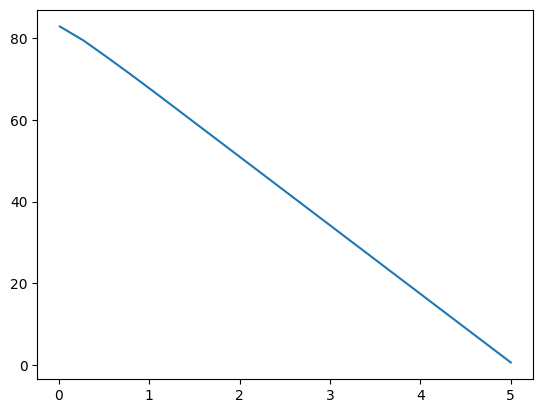

In [5]:
I_e_T_energy = np.loadtxt('intra_energy.txt', delimiter=',')
plt.plot(E_em_vals, np.log10(I_e_T), label = 'momentum')
plt.plot(E_em_vals, np.log10(I_e_T_energy), label = 'energy')
plt.xlabel('Energy [eV]')
plt.ylabel('log10(Emission Intensity)')
plt.legend()
plt.show()

In [307]:
rel_diff = np.abs(I_e_T - I_e_T_energy) / I_e_T_energy
plt.plot(E_em_vals, np.log10(rel_diff))
plt.xlabel('Emission Energy [eV]')
plt.ylabel('log10(Relative Difference)')

Text(0, 0.5, 'log10(Relative Difference)')

In [308]:
# # 2D integration over k1 and k2 for a single emission energy value
# def I_e_T_E(E_em):
#     k1_limits = [0, k_max]
#     k2_limits = lambda k1: [0, k_max - k1]
#     result, error = nquad(j_T, [k1_limits, k2_limits], args=(E_em,))
#     return result

# E_em_vals = np.linspace(0.01, 6.0, 100)
# I_e_T = np.array( [I_e_T_E(E_em) for E_em in E_em_vals] )

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def E_e_n(k):
    # Example implementation, replace with your actual function
    return k**2  # This is just a placeholder

def G_n(k1, k2, E_em):
    Norm = 1 / (sigma * np.sqrt(2 * np.pi))
    energy_diff = E_e_n(k1) - E_e_n(k2) - E_em
    return Norm * np.exp(-(energy_diff**2) / (2 * sigma**2))

# Parameters
k_min = 0
k_max = 2 * np.pi  # Assuming k_F is pi for this example
N = 5000
sigma = 0.01
E_em = 2.0

# Create k1 and k2 ranges
k1 = np.linspace(k_min, k_max, N)
k2 = np.linspace(k_min, k_max, N)
K1, K2 = np.meshgrid(k1, k2)

# Compute G_n values
Z = G_n(K1, K2, E_em)

# Smooth the data to reduce artifacts
Z_smoothed = gaussian_filter(Z, sigma=1)

# Plotting with contourf
plt.figure(figsize=(12, 8))
contour = plt.contourf(K1, K2, Z_smoothed, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('k1 [1/m]')
plt.ylabel('k2 [1/m]')
plt.title('G(k1, k2, 2.0) Contour Plot')
plt.show()

# fig = plt.figure(figsize=(30, 8))
# ax = fig.add_subplot(111, projection='3d')

# # ax.plot_wireframe(K1, K2, Z, rstride=10, cstride=10)
# ax.contour3D(K1, K2, Z, 500, cmap='viridis')
# ax.set_xlabel('k1 [1/m]')
# ax.set_ylabel('k2 [1/m]')
# # ax.view_init(elev=30, azim=45)
# ax.set_zlabel('G(k1, k2, 2.0)')
# plt.show()

KeyboardInterrupt: 

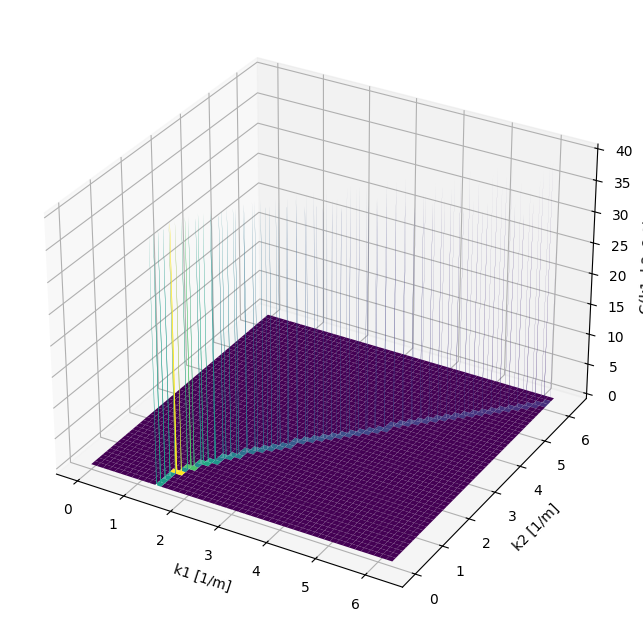

In [ ]:
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K1, K2, Z, cmap='viridis')
ax.set_xlabel('k1 [1/m]')
ax.set_ylabel('k2 [1/m]')
ax.set_zlabel('G(k1, k2, 2.0)')
plt.show()

In [ ]:
def f()